<a href="https://colab.research.google.com/github/meheraj2325/Frequent-Pattern-Mining-Algorithm-Implementation---Apriori/blob/main/Data_Mining_Apriori_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing necessary libraries


In [36]:
import numpy as np
import pandas as pd
import tracemalloc
import copy
import re
import csv
import time
import matplotlib.pyplot as plt

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

## Algorithm Directory path

In [37]:
# All the datasets are loaded from this directory and
# All the results are stored in this directory
directoryPath = '/content/drive/MyDrive/Colab Notebooks/Data Mining Assignments/Frequent Pattern Mining'

## Node Class

In [38]:
class Node:
  def __init__(self, parent, depth):
    self.parent = parent
    self.children = dict()
    self.lenOfLongestPath = 0
    self.supportCnt = 0
    self.depth = depth

  def get_parent(self):
    return self.parent

  def get_depth(self):
    return self.depth

  def get_children(self):
    return self.children

  def get_lenOfLongestPath(self):
    return self.lenOfLongestPath

  def get_supportCnt(self):
    return self.supportCnt

  def increment_supportCnt_by_one(self):
    self.supportCnt += 1

  def set_supportCnt(self, cnt):
    self.supportCnt = cnt

  def set_lenOfLongestPath(self, length):
    self.lenOfLongestPath = length

  def print_node(self):
    print(self)
    print("parent = {}".format(self.parent))
    print("children = {}".format(self.children))
    print("Support Count = {}, depth = {}, length of longest path = {}".format(self.supportCnt, self.depth, self.lenOfLongestPath))

  def insert_child(self, childNode, edge):
    self.children[edge] = childNode

  def delete_child(self, edge):
    del self.children[edge]

## Utility functions for apriori

In [39]:
def sort_transactions(dataset):
  for i in range(len(dataset)):
    dataset[i] = np.unique(dataset[i])
    
  return dataset

In [40]:
def generate_one_itemset(dataset):
  transactions = []
  for transaction in dataset:
    for item in transaction:
      transactions.append(item)

  return np.unique(transactions, return_counts=True)

In [41]:
def check_subset_frequent(node, itemSet, skipIdx, curIdx, itemSetLength):
  if itemSetLength < 0 or node.get_lenOfLongestPath() < itemSetLength:
    return False

  if itemSetLength == 0 or curIdx >= len(itemSet):
    return True

  if itemSet[curIdx] in node.children:
    nextIdx = curIdx + 1 if (skipIdx != curIdx + 1) else curIdx + 2 
    return check_subset_frequent(node.children[itemSet[curIdx]], itemSet, skipIdx, nextIdx, itemSetLength-1)

  return False

In [42]:
def prune_candidate(root, itemSet, curItemSetLength): 
  for i in range(len(itemSet)-2):
    start = 1 if (i==0) else 0
    isSubsetFrequent = check_subset_frequent(root, itemSet, i, start, curItemSetLength-1)
    if not isSubsetFrequent:
      return True

  return False

In [43]:
itemSetForSubsetCheck = np.array([])
def generate_candidates_with_pruning(root, node, curItemSetLength):
  global itemSetForSubsetCheck
  candidateCnt = 0
  edges = list(node.children.keys())
  mxLenForNode = -1
  for i in range(len(edges)):
    child = node.children[edges[i]]
    if child.get_lenOfLongestPath() + 1 == curItemSetLength - child.get_depth():
      itemSetForSubsetCheck = np.append(itemSetForSubsetCheck, edges[i])
      if len(child.children) == 0:
        mxLenForChild = -1
        for j in range(i+1, len(edges)):
          itemSetForSubsetCheck = np.append(itemSetForSubsetCheck, edges[j])
          if not prune_candidate(root, itemSetForSubsetCheck, curItemSetLength):
            newChildNode = Node(parent = child, depth = child.get_depth() + 1)
            child.insert_child(newChildNode, edges[j])
            mxLenForChild = max(mxLenForChild, newChildNode.get_lenOfLongestPath())
            candidateCnt += 1
          
          itemSetForSubsetCheck = itemSetForSubsetCheck[:-1]

        # update length of longest path from this node
        child.set_lenOfLongestPath(mxLenForChild + 1)
      else:
        candidateCnt += generate_candidates_with_pruning(root, child, curItemSetLength)
      
      itemSetForSubsetCheck = itemSetForSubsetCheck[:-1]

    mxLenForNode = max(mxLenForNode, child.get_lenOfLongestPath())

  node.set_lenOfLongestPath(mxLenForNode + 1)
  return candidateCnt 

In [44]:
def generate_candidates(node, curItemSetLength):
  candidateCnt = 0
  edges = list(node.children.keys())
  mxLenForNode = -1
  for i in range(len(edges)):
    child = node.children[edges[i]]
    if child.get_lenOfLongestPath() + 1 == curItemSetLength - child.get_depth():
      if len(child.children) == 0:
        mxLenForChild = -1
        for j in range(i+1, len(edges)):
          newChildNode = Node(parent = child, depth = child.get_depth() + 1)
          child.insert_child(newChildNode, edges[j])
          mxLenForChild = max(mxLenForChild, newChildNode.get_lenOfLongestPath())
          candidateCnt += 1
        
        # update length of longest path from this node
        child.set_lenOfLongestPath(mxLenForChild + 1)
      
      else:
        candidateCnt += generate_candidates(child, curItemSetLength)

    mxLenForNode = max(mxLenForNode, child.get_lenOfLongestPath())

  node.set_lenOfLongestPath(mxLenForNode + 1)
  return candidateCnt 

In [45]:
def update_support_cnt(node, transaction, curIdx, itemSetLength):
  if itemSetLength < 0 or node.get_lenOfLongestPath() < itemSetLength:
    return

  if itemSetLength == 0 and len(node.children) == 0:
    node.increment_supportCnt_by_one()
    return

  for idx in range(curIdx, len(transaction) - itemSetLength + 1):
    if transaction[idx] in node.children:
      update_support_cnt(node.children[transaction[idx]], transaction, curIdx+1, itemSetLength-1)

In [46]:
def delete_nonFrequent_itemsets(node, curItemSetLength, minSupportThreshold):
  if node.get_lenOfLongestPath() < curItemSetLength - node.get_depth():
    return 0

  deletedItemsetsCnt = 0
  mxLen = -1
  edges = list(node.children.keys())
  for edge in edges:
    child = node.children[edge]
    if len(child.children) == 0 and child.get_depth() == curItemSetLength:
      if child.get_supportCnt() < minSupportThreshold:
        node.delete_child(edge)
        deletedItemsetsCnt += 1
      else:
        mxLen = max(mxLen, child.get_lenOfLongestPath())
    else:  
      deletedItemsetsCnt += delete_nonFrequent_itemsets(child, curItemSetLength, minSupportThreshold)
      mxLen = max(mxLen, child.get_lenOfLongestPath())  

  node.set_lenOfLongestPath(mxLen + 1)
  return deletedItemsetsCnt

In [47]:
container = np.array([])

def print_trie(node):
  global container
  if len(node.children) == 0:
    print(container)
    return

  for key, child in node.children.items():
    container = np.append(container, key)
    # print(key, child.get_lenOfLongestPath())
    print_trie(child)  
    container = container[:-1]

In [48]:
container = np.array([])

def print_trie_for_specific_length_candidates(node, curItemSetLength):
  global container
  if node.get_lenOfLongestPath() < curItemSetLength - node.get_depth():
    return 0

  if len(node.children) == 0:
    print("Itemset: {} Support count: {}".format(container, node.get_supportCnt()))
    return 1

  cnt = 0
  for key, child in node.children.items():
    container = np.append(container, key)
    cnt += print_trie_for_specific_length_candidates(child, curItemSetLength)  
    container = container[:-1]

  return cnt

##Dataset load


In [49]:
def load_dataset(datasetName,delimiter = ' ', number = True):
  filepath = '{}/{}'.format(directoryPath,datasetName)
  dataset = []
  numOfTransactions = 0
  with open(filepath) as f:
    for i, line in enumerate(f):
      transaction = line.strip().split(delimiter) 
      dataset.append(transaction if not number else np.array(transaction, dtype = int))
      numOfTransactions += 1
  
  # print(numOfTransactions)
  return dataset, numOfTransactions

##Apriori Algorithm

In [50]:
def apriori(dataset, minSupportThreshold):
  dataset = sort_transactions(dataset)
  # print(dataset)

  totalFrequentItemsets = 0
  curItemSetLength = 1

  # Root of the trie
  root = Node(parent = -1, depth = 0)

  individualItems, itemCounts = generate_one_itemset(dataset)
  # print(individualItems)
  # print(itemCounts)

  numOfFrequentOneItemsets = 0
  mxLen = -1
  for idx, item in enumerate(individualItems):
    if itemCounts[idx] >= minSupportThreshold:
      newChild = Node(parent = root, depth = root.get_depth() + 1)
      newChild.set_supportCnt(itemCounts[idx])
      mxLen = max(mxLen, newChild.get_lenOfLongestPath()) 
      root.insert_child(newChild, item)
      numOfFrequentOneItemsets += 1

  root.set_lenOfLongestPath(mxLen + 1)
  totalFrequentItemsets += numOfFrequentOneItemsets

  # print("Total frequent {}-itemsets : {}".format(curItemSetLength, numOfFrequentOneItemsets))
  # print("Frequent {}-itemsets are listed below: ".format(curItemSetLength))
  # print_trie_for_specific_length_candidates(root, curItemSetLength)
  # print("\n")

  # Now Trie has all frequent 1-itemset
  # SO now we need to generate candidates for 2-itemset and determine frequent 2-itemset and so on.

  curItemSetLength = 2

  while True:
    numOfCandidates = generate_candidates(root, curItemSetLength) if curItemSetLength == 2 else generate_candidates_with_pruning(root, root, curItemSetLength)
    # print("Number of candidates generated for level {}: {}".format( curItemSetLength, numOfCandidates))
    
    if numOfCandidates == 0:
      break
    
    for transaction in dataset:
      update_support_cnt(root, transaction, 0, curItemSetLength)

    # print_trie_for_specific_length_candidates(root, curItemSetLength)
    # print("\n")
    
    numOfDeletedItemsets = delete_nonFrequent_itemsets(root, curItemSetLength, minSupportThreshold)
    numOfFrequentKItemsets = numOfCandidates - numOfDeletedItemsets
    if numOfFrequentKItemsets == 0:
      break    

    totalFrequentItemsets += numOfFrequentKItemsets
    # print("Total frequent {}-itemsets : {}".format(curItemSetLength, numOfFrequentKItemsets))
    # print("Frequent {}-itemsets are listed below: ".format(curItemSetLength))
    # print_trie_for_specific_length_candidates(root, curItemSetLength)
    # print("\n")

    curItemSetLength += 1

  # clearing global variables
  global itemSetForSubsetCheck, container
  itemSetForSubsetCheck = np.array([])
  container = np.array([])
  
  return totalFrequentItemsets

### Sample dataset-1 

In [51]:
dataset, numOfTransactions = load_dataset(datasetName='sampleDataset-1.csv', number = False)

tracemalloc.start()
start = time.time()

totalFrequentItemsets = apriori(dataset, minSupportThreshold=3)
print("Total number of frequent itemsets : {}".format(totalFrequentItemsets))

end = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(end-start)

Total number of frequent itemsets : 18
Current memory usage is 0.012533MB; Peak was 0.02704MB
0.0022504329681396484


### Sample dataset-2 

In [52]:
dataset, numOfTransactions = load_dataset(datasetName='sampleDataset-2.csv', number = False)

tracemalloc.start()
start = time.time()

totalFrequentItemsets = apriori(dataset, minSupportThreshold=2)
print("Total number of frequent itemsets : {}".format(totalFrequentItemsets))

end = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(end-start)

Total number of frequent itemsets : 13
Current memory usage is 0.010324MB; Peak was 0.026557MB
0.0016109943389892578


### Sample dataset-3 

In [53]:
dataset, numOfTransactions = load_dataset(datasetName='sampleDataset-3.csv', delimiter = ', ', number = False)

tracemalloc.start()
start = time.time()

totalFrequentItemsets = apriori(dataset, minSupportThreshold=2)
print("Total number of frequent itemsets : {}".format(totalFrequentItemsets))

end = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(end-start)

Total number of frequent itemsets : 16
Current memory usage is 0.015905MB; Peak was 0.031731MB
0.0021173954010009766


### Write Output to File

In [54]:
def write_output_to_file(permission, datasetName, algoName, result):
  output = algoName
  for val in result:
    output += ',{}'.format(str(val))
  output += '\n'
  print(output)

  filepath = '{}/{}'.format(directoryPath, datasetName)
  with open(filepath, permission) as f:
    f.write(output)


### Chess

In [56]:
# dataset, numOfTransactions = load_dataset(datasetName='chess.dat', number = True)
# # print(dataset)

# chessMemory = np.array([])
# chessTime = np.array([])
# chessFrequentItemsets = np.array([])

# minRelativeSupport = np.arange(0.95, 0.74, -0.04)
# print(minRelativeSupport)
# minAbsoluteSupport = np.array([np.ceil(val * numOfTransactions) for val in minRelativeSupport])
# print(minAbsoluteSupport)

# for threshold in minAbsoluteSupport:  
#   tracemalloc.start()
#   start = time.time()

#   totalFrequentItemsets = apriori(dataset, minSupportThreshold=threshold)
#   print("Total number of frequent itemsets : {}".format(totalFrequentItemsets))

#   end = time.time()
#   current, peak = tracemalloc.get_traced_memory()
#   tracemalloc.stop()

#   chessMemory = np.append(chessMemory, peak/10**6)
#   chessTime = np.append(chessTime, end-start)
#   chessFrequentItemsets = np.append(chessFrequentItemsets, totalFrequentItemsets)

#   print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
#   print(end-start)

# chessMinSupport = minRelativeSupport*100.00

# print("chessMinSupport : {}".format(chessMinSupport))
# print("chessMemory : {}".format(chessMemory))
# print("chessTime : {}".format(chessTime))
# print("chessFrequentItemsets : {}".format(chessFrequentItemsets))

In [29]:
# write_output_to_file('a','chessMemory.csv', 'Apriori', chessMemory)
# write_output_to_file('a','chessTime.csv', 'Apriori', chessTime)
# write_output_to_file('a','chessFrequentItemsets.csv', 'Apriori', chessFrequentItemsets)

### Mushroom

In [ ]:
# dataset, numOfTransactions = load_dataset(datasetName='mushroom.dat', number = True)
# # print(dataset)

# mushroomMemory = np.array([])
# mushroomTime = np.array([])
# mushroomFrequentItemsets = np.array([])

# minRelativeSupport = np.arange(0.60, 0.39, -0.04)
# print(minRelativeSupport)
# minAbsoluteSupport = np.array([np.ceil(val * numOfTransactions) for val in minRelativeSupport])
# print(minAbsoluteSupport)

# for threshold in minAbsoluteSupport:  
#   tracemalloc.start()
#   start = time.time()

#   totalFrequentItemsets = apriori(dataset, minSupportThreshold=threshold)
#   print("Total number of frequent itemsets : {}".format(totalFrequentItemsets))

#   end = time.time()
#   current, peak = tracemalloc.get_traced_memory()
#   tracemalloc.stop()

#   mushroomMemory = np.append(mushroomMemory, peak/10**6)
#   mushroomTime = np.append(mushroomTime, end-start)
#   mushroomFrequentItemsets = np.append(mushroomFrequentItemsets, totalFrequentItemsets)

#   print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
#   print(end-start)

# mushroomMinSupport = minRelativeSupport*100.00

# print("mushroomMinSupport : {}".format(mushroomMinSupport))
# print("mushroomMemory : {}".format(mushroomMemory))
# print("mushroomTime : {}".format(mushroomTime))
# print("mushroomFrequentItemsets : {}".format(mushroomFrequentItemsets))

[0.6  0.56 0.52 0.48 0.44 0.4 ]
[4875. 4550. 4225. 3900. 3575. 3250.]
Total number of frequent itemsets : 51
Current memory usage is 0.686644MB; Peak was 10.17272MB
4.370220899581909
Total number of frequent itemsets : 85
Current memory usage is 0.691612MB; Peak was 10.170698MB
6.3044517040252686
Total number of frequent itemsets : 137
Current memory usage is 0.713061MB; Peak was 10.170303MB
9.06063199043274
Total number of frequent itemsets : 209
Current memory usage is 0.730397MB; Peak was 10.170608MB
13.249307632446289
Total number of frequent itemsets : 345
Current memory usage is 0.789761MB; Peak was 10.170458MB
20.386184692382812
Total number of frequent itemsets : 565
Current memory usage is 0.905253MB; Peak was 10.170303MB
29.135249137878418
mushroomMinSupport : [60. 56. 52. 48. 44. 40.]
mushroomMemory : [10.17272  10.170698 10.170303 10.170608 10.170458 10.170303]
mushroomTime : [ 4.3702209   6.3044517   9.06063199 13.24930763 20.38618469 29.13524914]
mushroomFrequentItemsets 

In [ ]:
# write_output_to_file('a','mushroomMemory.csv', 'Apriori', mushroomMemory)
# write_output_to_file('a','mushroomTime.csv', 'Apriori', mushroomTime)
# write_output_to_file('a','mushroomFrequentItemsets.csv', 'Apriori', mushroomFrequentItemsets)

Apriori,51.0,85.0,137.0,209.0,345.0,565.0



### Retail 

In [ ]:
# dataset, numOfTransactions = load_dataset(datasetName='retail.dat', number = True)
# # print(dataset)

# retailMemory = np.array([])
# retailTime = np.array([])
# retailFrequentItemsets = np.array([])

# minRelativeSupport = np.arange(0.5, 0.29, -0.04)/100
# print(minRelativeSupport)
# minAbsoluteSupport = np.array([np.ceil(val * numOfTransactions) for val in minRelativeSupport])
# print(minAbsoluteSupport)

# for threshold in minAbsoluteSupport:  
#   tracemalloc.start()
#   start = time.time()

#   totalFrequentItemsets = apriori(dataset, minSupportThreshold=threshold)
#   print("Total number of frequent itemsets : {}".format(totalFrequentItemsets))

#   end = time.time()
#   current, peak = tracemalloc.get_traced_memory()
#   tracemalloc.stop()

#   retailMemory = np.append(retailMemory, peak/10**6)
#   retailTime = np.append(retailTime, end-start)
#   retailFrequentItemsets = np.append(retailFrequentItemsets, totalFrequentItemsets)

#   print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
#   print(end-start)

# retailMinSupport = minRelativeSupport*100.00

# print("retailMinSupport : {}".format(retailMinSupport))
# print("retailMemory : {}".format(retailMemory))
# print("retailTime : {}".format(retailTime))
# print("retailFrequentItemsets : {}".format(retailFrequentItemsets))

[0.005  0.0046 0.0042 0.0038 0.0034 0.003 ]
[441. 406. 371. 336. 300. 265.]
Total number of frequent itemsets : 580
Current memory usage is 8.333315MB; Peak was 52.99057MB
13.923942804336548
Total number of frequent itemsets : 685
Current memory usage is 8.767657MB; Peak was 52.945312MB
14.969637393951416
Total number of frequent itemsets : 785
Current memory usage is 9.140001MB; Peak was 52.946304MB
15.526808738708496
Total number of frequent itemsets : 915
Current memory usage is 9.625393MB; Peak was 52.946136MB
16.90703582763672
Total number of frequent itemsets : 1135
Current memory usage is 11.039378MB; Peak was 52.946168MB
18.62132716178894
Total number of frequent itemsets : 1393
Current memory usage is 12.934326MB; Peak was 66.805321MB
20.62048316001892
retailMinSupport : [0.5  0.46 0.42 0.38 0.34 0.3 ]
retailMemory : [52.99057  52.945312 52.946304 52.946136 52.946168 66.805321]
retailTime : [13.9239428  14.96963739 15.52680874 16.90703583 18.62132716 20.62048316]
retailFrequen

In [ ]:
# write_output_to_file('a','retailMemory.csv', 'Apriori', retailMemory)
# write_output_to_file('a','retailTime.csv', 'Apriori', retailTime)
# write_output_to_file('a','retailFrequentItemsets.csv', 'Apriori', retailFrequentItemsets)

Apriori,52.99057,52.945312,52.946304,52.946136,52.946168,66.805321

Apriori,13.923942804336548,14.969637393951416,15.526808738708496,16.90703582763672,18.62132716178894,20.62048316001892

Apriori,580.0,685.0,785.0,915.0,1135.0,1393.0



### T10I4D100K

In [57]:
# dataset, numOfTransactions = load_dataset(datasetName='T10I4D100K.dat', number = True)
# # print(dataset)

# T10I4D100KMemory = np.array([])
# T10I4D100KTime = np.array([])
# T10I4D100KFrequentItemsets = np.array([])

# minRelativeSupport = np.arange(0.04, 0.019, -0.004)

# print(minRelativeSupport)
# minAbsoluteSupport = np.array([np.ceil(val * numOfTransactions) for val in minRelativeSupport])
# print(minAbsoluteSupport)

# for threshold in minAbsoluteSupport:  
#   tracemalloc.start()
#   start = time.time()

#   totalFrequentItemsets = apriori(dataset, minSupportThreshold=threshold)
#   print("Total number of frequent itemsets : {}".format(totalFrequentItemsets))

#   end = time.time()
#   current, peak = tracemalloc.get_traced_memory()
#   tracemalloc.stop()

#   T10I4D100KMemory = np.append(T10I4D100KMemory, peak/10**6)
#   T10I4D100KTime = np.append(T10I4D100KTime, end-start)
#   T10I4D100KFrequentItemsets = np.append(T10I4D100KFrequentItemsets, totalFrequentItemsets)

#   print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
#   print(end-start)

# T10I4D100KMinSupport = minRelativeSupport*100.00

# print("T10I4D100KMinSupport : {}".format(T10I4D100KMinSupport))
# print("T10I4D100KMemory : {}".format(T10I4D100KMemory))
# print("T10I4D100KTime : {}".format(T10I4D100KTime))
# print("T10I4D100KFrequentItemsets : {}".format(T10I4D100KFrequentItemsets))

[0.04  0.036 0.032 0.028 0.024 0.02 ]
[4000. 3601. 3201. 2801. 2401. 2001.]
Total number of frequent itemsets : 26
Current memory usage is 20.503279MB; Peak was 71.589935MB
3.780806541442871
Total number of frequent itemsets : 39
Current memory usage is 8.050872MB; Peak was 59.128224MB
4.207650661468506
Total number of frequent itemsets : 47
Current memory usage is 8.066608MB; Peak was 59.128248MB
4.503385305404663
Total number of frequent itemsets : 74
Current memory usage is 8.138216MB; Peak was 59.1282MB
5.602600812911987
Total number of frequent itemsets : 116
Current memory usage is 8.319041MB; Peak was 59.128288MB
7.017274379730225
Total number of frequent itemsets : 155
Current memory usage is 8.517577MB; Peak was 59.128304MB
8.718206405639648
T10I4D100KMinSupport : [4.  3.6 3.2 2.8 2.4 2. ]
T10I4D100KMemory : [71.589935 59.128224 59.128248 59.1282   59.128288 59.128304]
T10I4D100KTime : [3.78080654 4.20765066 4.50338531 5.60260081 7.01727438 8.71820641]
T10I4D100KFrequentItemse

In [58]:
# write_output_to_file('a','T10I4D100KMemory.csv', 'Apriori', T10I4D100KMemory)
# write_output_to_file('a','T10I4D100KTime.csv', 'Apriori', T10I4D100KTime)
# write_output_to_file('a','T10I4D100KFrequentItemsets.csv', 'Apriori', T10I4D100KFrequentItemsets)

Apriori,71.589935,59.128224,59.128248,59.1282,59.128288,59.128304

Apriori,3.780806541442871,4.207650661468506,4.503385305404663,5.602600812911987,7.017274379730225,8.718206405639648

Apriori,26.0,39.0,47.0,74.0,116.0,155.0



### Kosarak

In [ ]:
# dataset, numOfTransactions = load_dataset(datasetName='kosarak.dat', number = True)
# # print(dataset)

# kosarakMemory = np.array([])
# kosarakTime = np.array([])
# kosarakFrequentItemsets = np.array([])

# minRelativeSupport = np.arange(7, 1, -1)/100.0
# print(minRelativeSupport)
# minAbsoluteSupport = np.array([np.ceil(val * numOfTransactions) for val in minRelativeSupport])
# print(minAbsoluteSupport)

# for threshold in minAbsoluteSupport:  
#   tracemalloc.start()
#   start = time.time()

#   totalFrequentItemsets = apriori(dataset, minSupportThreshold=threshold)
#   print("Total number of frequent itemsets : {}".format(totalFrequentItemsets))

#   end = time.time()
#   current, peak = tracemalloc.get_traced_memory()
#   tracemalloc.stop()

#   kosarakMemory = np.append(kosarakMemory, peak/10**6)
#   kosarakTime = np.append(kosarakTime, end-start)
#   kosarakFrequentItemsets = np.append(kosarakFrequentItemsets, totalFrequentItemsets)

#   print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
#   print(end-start)

# kosarakMinSupport = minRelativeSupport*100.00
# print("kosarakMinSupport : {}".format(kosarakMinSupport))
# print("kosarakMemory : {}".format(kosarakMemory))
# print("kosarakTime : {}".format(kosarakTime))
# print("kosarakFrequentItemsets : {}".format(kosarakFrequentItemsets))

[0.07 0.06 0.05 0.04 0.03 0.02]
[69301. 59401. 49501. 39601. 29701. 19801.]
Total number of frequent itemsets : 19
Current memory usage is 89.26032MB; Peak was 490.4566MB
61.47482371330261
Total number of frequent itemsets : 24
Current memory usage is 89.257424MB; Peak was 490.4548MB
72.95730900764465
Total number of frequent itemsets : 33
Current memory usage is 89.256868MB; Peak was 490.454728MB
90.81973314285278
Total number of frequent itemsets : 42
Current memory usage is 89.268316MB; Peak was 490.454792MB
102.27302551269531
Total number of frequent itemsets : 65
Current memory usage is 89.265028MB; Peak was 490.454736MB
111.32046604156494
Total number of frequent itemsets : 121
Current memory usage is 89.303329MB; Peak was 490.454736MB
156.62668371200562
kosarakMinSupport : [7. 6. 5. 4. 3. 2.]
kosarakMemory : [490.4566   490.4548   490.454728 490.454792 490.454736 490.454736]
kosarakTime : [ 61.47482371  72.95730901  90.81973314 102.27302551 111.32046604
 156.62668371]
kosarakFre

In [ ]:
# write_output_to_file('a','kosarakMemory.csv', 'Apriori', kosarakMemory)
# write_output_to_file('a','kosarakTime.csv', 'Apriori', kosarakTime)
# write_output_to_file('a','kosarakFrequentItemsets.csv', 'Apriori', kosarakFrequentItemsets)

Apriori,490.4566,490.4548,490.454728,490.454792,490.454736,490.454736

Apriori,61.47482371330261,72.95730900764465,90.81973314285278,102.27302551269531,111.32046604156494,156.62668371200562

Apriori,19.0,24.0,33.0,42.0,65.0,121.0



## Plotting graph

In [59]:
def plot_graph(dName):

  plotStyles = {
    'markers' : ["o","^","*","p","s","X","d"],
    'color' : ['#22a6b3','#30336b','#00cec9', '#0984e3',  '#6c5ce7' , '#00b894','#74b9ff', '#d63031', '#273c75',   '#74b9ff'],
    'lineStyle' : 'solid',
    'markerSize' :  10,
  }

  extension = ['Time', 'Memory']
  plt.figure(figsize=(10*len(extension),10))

  for i in range(len(extension)):
    df = pd.read_csv('{}/{}{}.csv'.format(directoryPath, dName, extension[i]), sep=",", index_col=['Method'])  
    # print(df)
    minSupportThreshold = np.array(df.columns, dtype= float)
    # print(minSupportThreshold)
    minSupportThreshold = np.round(minSupportThreshold, decimals=2)  
    noOfThresholds = len(minSupportThreshold)
    diffBetweenThresholds = abs(minSupportThreshold[0] - minSupportThreshold[1])
    # print(diffBetweenThresholds)

    methods = np.unique(df.index.get_level_values('Method'))
    noOfMethods = len(methods)    
    
    plt.subplot(1, len(extension), i + 1).set_title('Dataset: {}'.format(dName), fontsize=20)
    lines = []
    labels = []
    for j in range(noOfMethods):
      values = np.array(df.loc[methods[j]])
      # print(values)

      if extension[i] == 'Time':
        plt.ylabel('Runtime (sec)', fontsize=20)
      else:
        plt.ylabel('Memory (MB)', fontsize=20)
      plt.xlabel('Minimum Support (%)', fontsize=20)

      plt.xlim(minSupportThreshold[0] + diffBetweenThresholds/2, minSupportThreshold[noOfThresholds-1] - diffBetweenThresholds/2)

      line,  = plt.plot(minSupportThreshold, values, color=plotStyles['color'][j], linestyle=plotStyles['lineStyle'], 
      marker=plotStyles['markers'][j], markersize=plotStyles['markerSize'], label=methods[j])
      labels.append(methods[j])
      lines.append(line)

    plt.legend(lines, labels, prop={'size': 18})      
  plt.show()

In [60]:
def save_graph(dName, fileExtension='svg'):
  plotStyles = {
    'markers' : ["o","^","*","p","s","X","d"],
    'color' : ['#22a6b3','#30336b','#00cec9', '#0984e3',  '#6c5ce7' , '#00b894','#74b9ff', '#d63031', '#273c75',   '#74b9ff'],
    'lineStyle' : 'solid',
    'markerSize' :  10,
  }

  extension = ['Time', 'Memory']
  plt.figure(figsize=(10,10))

  for i in range(len(extension)):
    df = pd.read_csv('{}/{}{}.csv'.format(directoryPath, dName, extension[i]), sep=",", index_col=['Method'])  
    # print(df)
    minSupportThreshold = np.array(df.columns, dtype= float)
    # print(minSupportThreshold)
    minSupportThreshold = np.round(minSupportThreshold, decimals=2)
    noOfThresholds = len(minSupportThreshold)
    diffBetweenThresholds = abs(minSupportThreshold[0] - minSupportThreshold[1])
    # print(diffBetweenThresholds)

    methods = np.unique(df.index.get_level_values('Method'))
    noOfMethods = len(methods)    
    
    plt.clf()
    plt.title('Dataset: {}'.format(dName), fontsize=20)
    lines = []
    labels = []
    for j in range(noOfMethods):
      values = np.array(df.loc[methods[j]])
      # print(values)

      if extension[i] == 'Time':
        plt.ylabel('Runtime (sec)', fontsize=20)
      else:
        plt.ylabel('Memory (MB)', fontsize=20)
      plt.xlabel('Minimum Support (%)', fontsize=20)

      plt.xlim(minSupportThreshold[0] + diffBetweenThresholds/2, minSupportThreshold[noOfThresholds-1] - diffBetweenThresholds/2)

      line,  = plt.plot(minSupportThreshold, values, color=plotStyles['color'][j], linestyle=plotStyles['lineStyle'], 
      marker=plotStyles['markers'][j], markersize=plotStyles['markerSize'], label=methods[j])
      labels.append(methods[j])
      lines.append(line)

    plt.legend(lines, labels, prop={'size': 18})      
    plt.savefig('{}/Plots/{}{}.{}'.format(directoryPath, dName, extension[i], fileExtension))

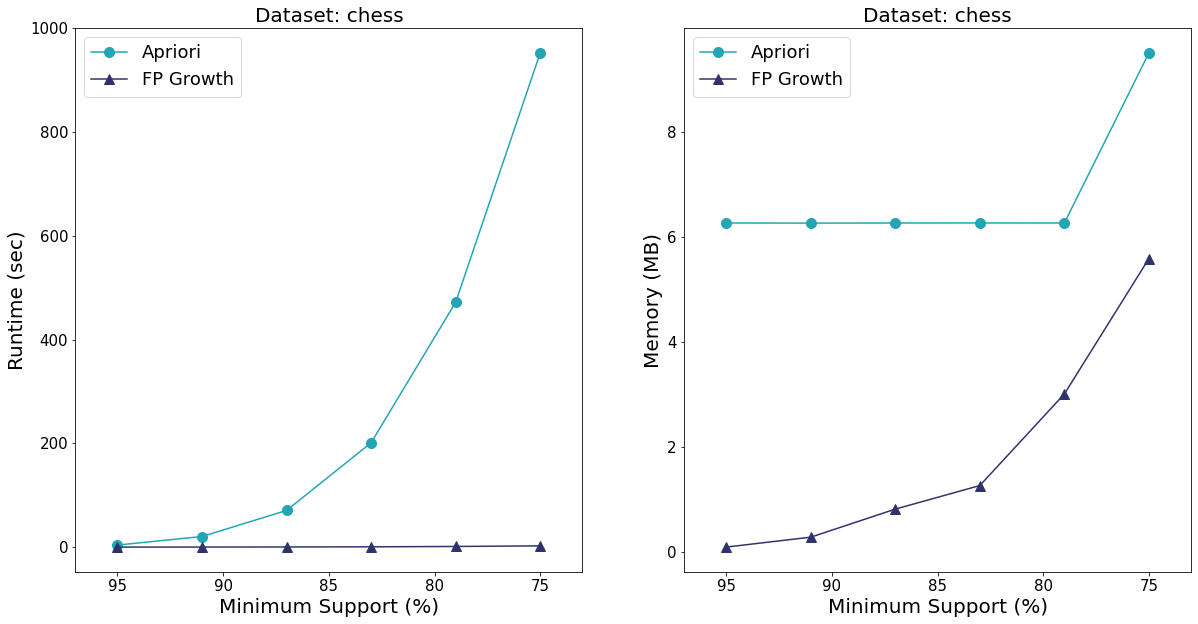

In [61]:
plot_graph('chess')
# save_graph('chess', 'svg')
# save_graph('chess', 'png')

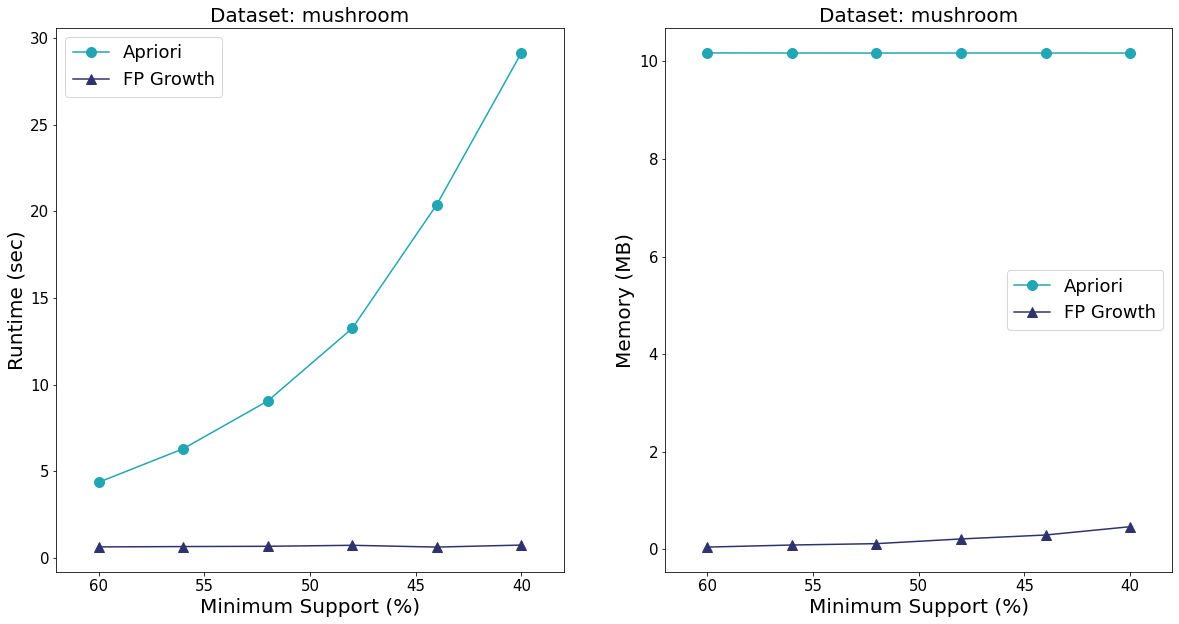

In [62]:
plot_graph('mushroom')
# save_graph('mushroom','svg')
# save_graph('mushroom', 'png')

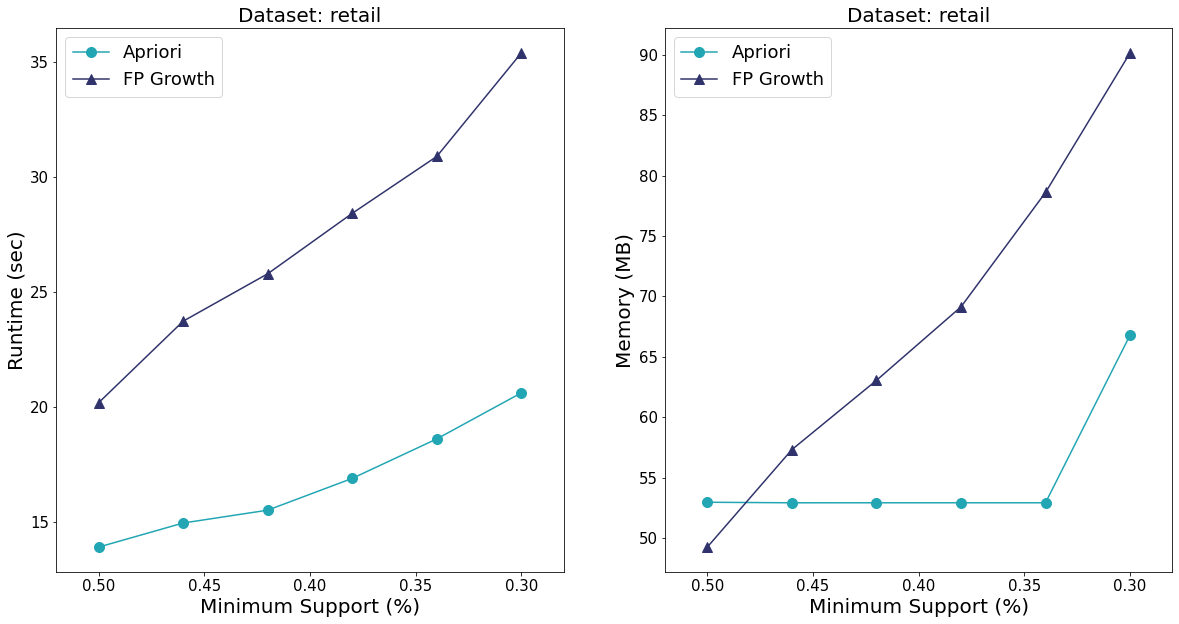

In [63]:
plot_graph('retail')
# save_graph('retail', 'svg')
# save_graph('retail', 'png')

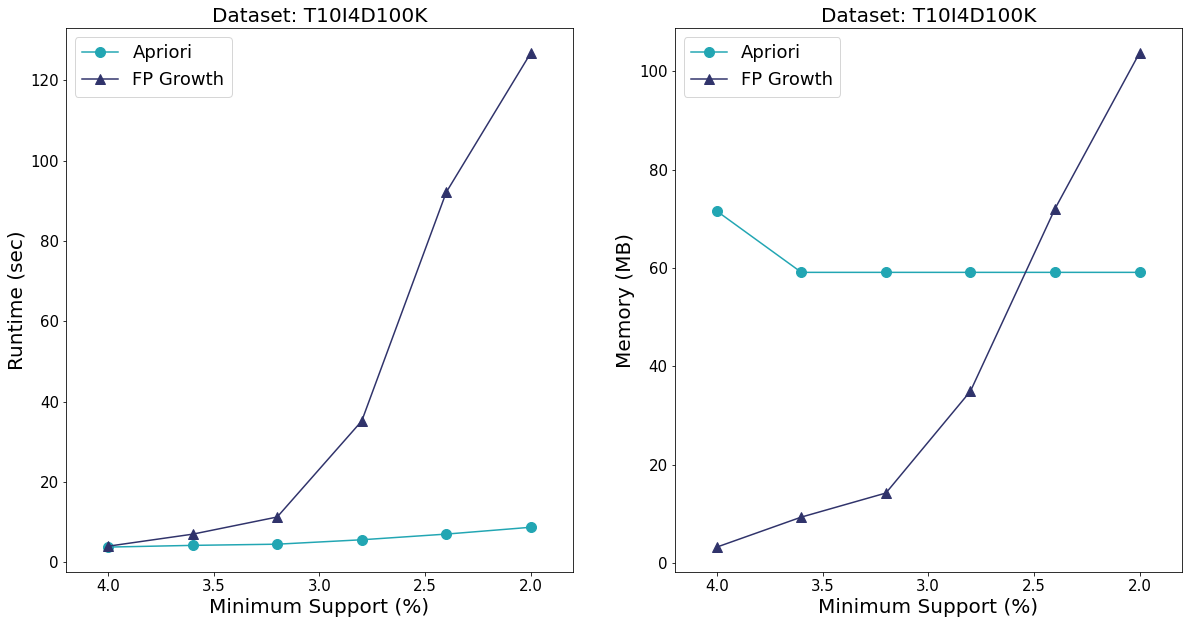

In [65]:
plot_graph('T10I4D100K')
# save_graph('T10I4D100K', 'svg')
# save_graph('T10I4D100K', 'png')

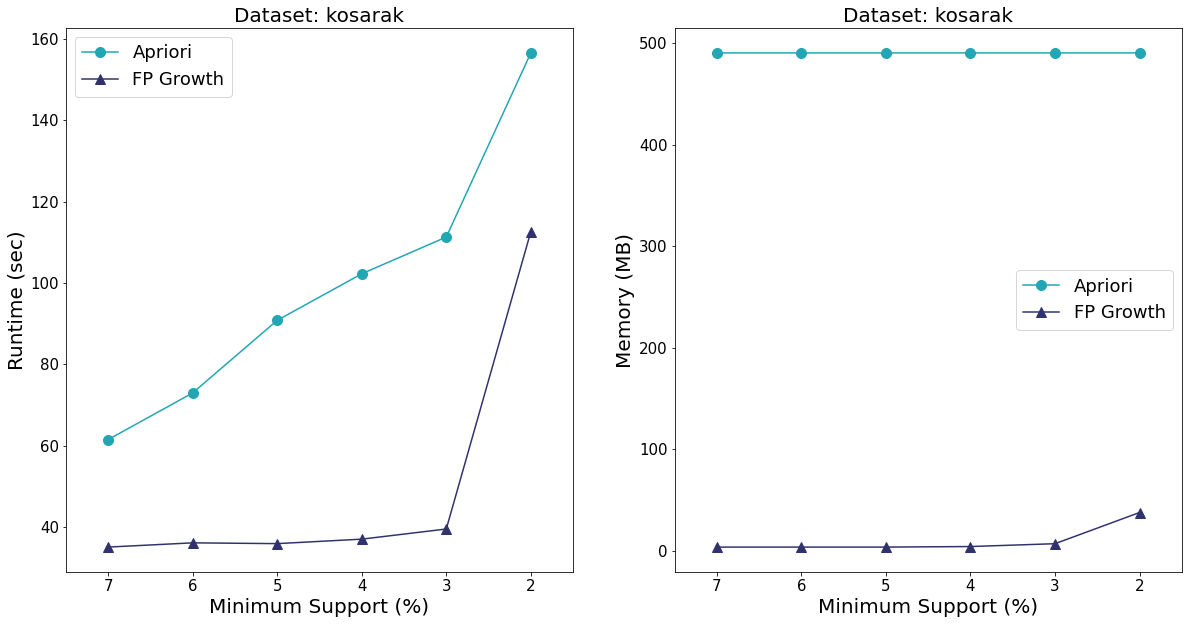

In [ ]:
plot_graph('kosarak')
# save_graph('kosarak', 'svg')
# save_graph('kosarak', 'png')